<a href="https://colab.research.google.com/github/aurorali17/STA365/blob/main/sta365_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np; from scipy import stats; import matplotlib.pyplot as plt
import pandas as pd
import requests
import random
import os

os.chdir('/content/drive/MyDrive')

df = pd.read_csv("bodyfat.csv")
df.describe()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,1.055574,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,0.019031,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.995000,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,1.041400,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,1.054900,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,1.070400,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,1.108900,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


Question 1

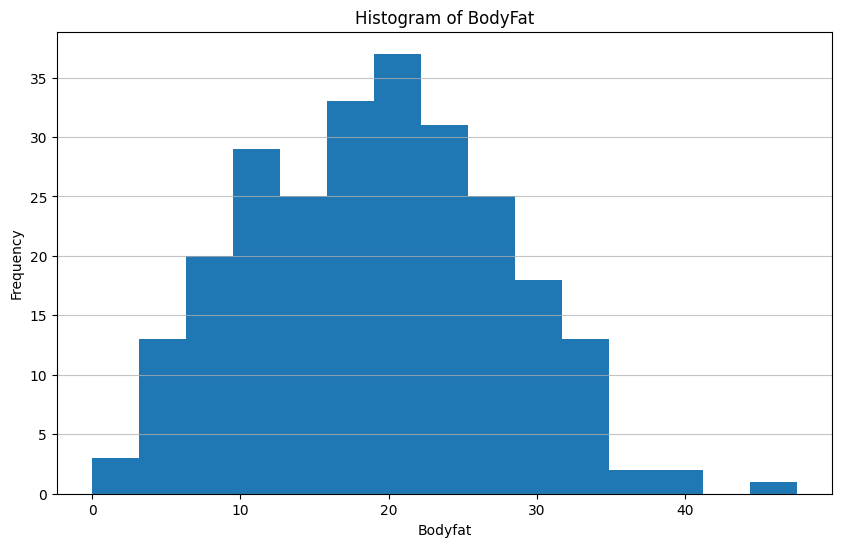

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df["BodyFat"], bins=15)
plt.title('Histogram of BodyFat')
plt.xlabel('Bodyfat')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


HMC Split-Rhats {'theta': 0.9998, 'phi': 1.0004}


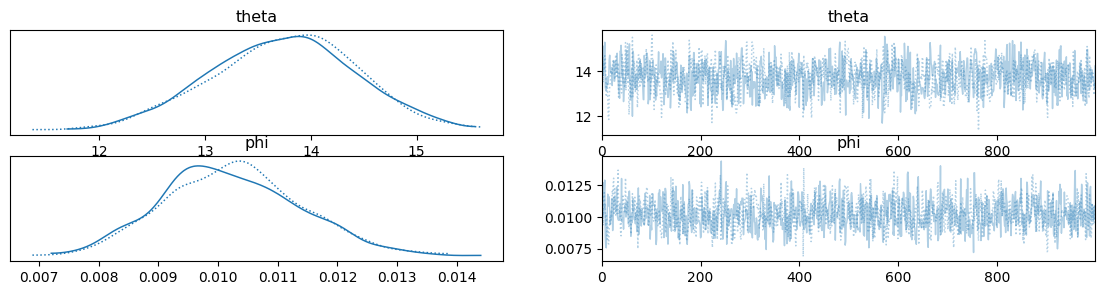

In [8]:
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt


body_fat_data = df['BodyFat'].values

theta_0, tau = 0, 1  # For the normal distribution
alpha, beta = 2, 1/2  # For the gamma distribution

# Define the PyMC model
normal_gamma_BodyFat_model=pm.Model()
with normal_gamma_BodyFat_model:
    theta = pm.Normal("theta", mu=theta_0, sigma=tau)
    phi = pm.Gamma("phi", alpha=alpha, beta=beta)
    x_obs = pm.Normal("x_obs", mu=theta, sigma=1/phi**0.5, observed=body_fat_data)
random.seed(333)
with normal_gamma_BodyFat_model:
  idata_HMC = pm.sample()


fig,ax = plt.subplots(2,2, figsize=(14,3))
az.plot_trace(idata_HMC, axes=ax[:2,:2])
print("HMC Split-Rhats", {k: np.round(v.values,4) for k,v in az.rhat(idata_HMC).items()})

In [ ]:
print("number of MCMC samples:", idata_HMC.posterior['phi'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2) # https://python.arviz.org/en/stable/api/generated/arviz.ess.html

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,13.75,0.7,12.32,15.00,0.02,0.02,990.69,1112.33,1.01
phi,0.01,0.0,0.01,0.01,0.00,0.00,915.47,1329.74,1.00


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

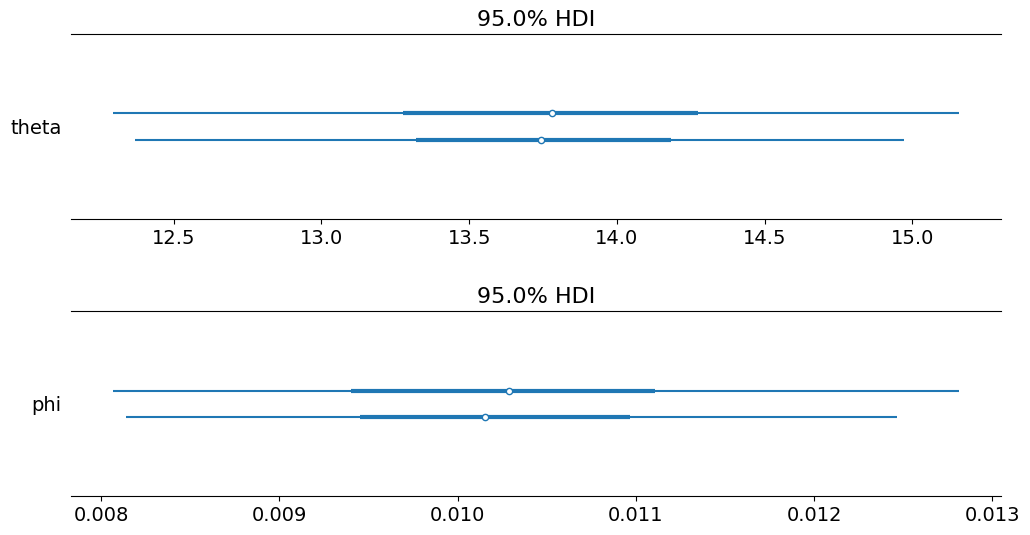

In [ ]:
fig,ax = plt.subplots(2,1,figsize =(12,6))
plt.subplots_adjust(hspace=0.5)
az.plot_forest(idata_HMC, var_names=["theta"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(idata_HMC, var_names=["phi"], combined=False, hdi_prob=0.95, ax=ax[1])


Question 2

In [ ]:
from scipy.stats import shapiro
normality_tests = {}
for column in df.columns:
    # Skip non-numeric columns
    if df[column].dtype in ['int64', 'float64']:
        stat, p_value = shapiro(df[column])
        normality_tests[column] = p_value
normality_test_results = pd.DataFrame(list(normality_tests.items()), columns=['Column', 'P-Value'])
non_normal_columns = normality_test_results[normality_test_results['P-Value'] < 0.05]
non_normal_columns


,Column,P-Value
2,Age,1.043477e-03
3,Weight,1.709552e-08
4,Height,3.225425e-21
5,Neck,4.916591e-05
6,Chest,1.174791e-04
7,Abdomen,9.830832e-06
8,Hip,3.019451e-10
9,Thigh,1.071427e-05
10,Knee,3.305882e-03
11,Ankle,8.782356e-15


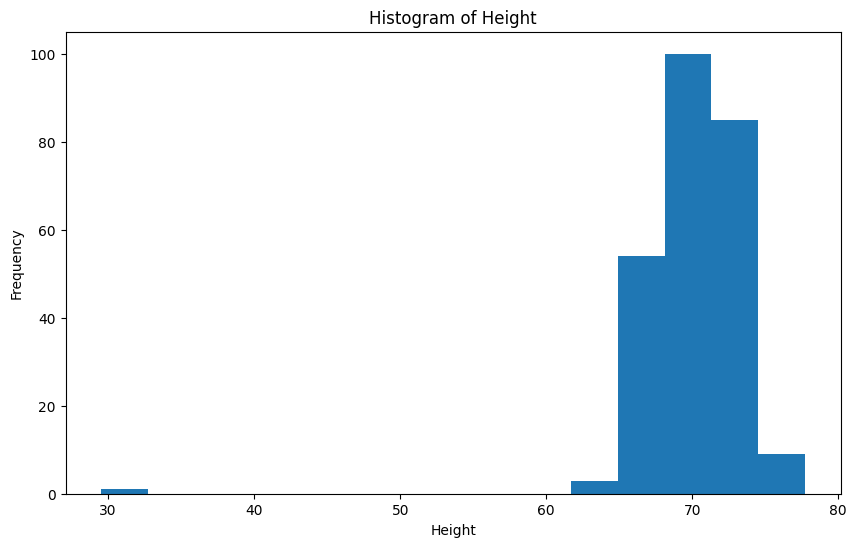

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df["Height"], bins=15)
plt.title('Histogram of Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.show()

So, I choose column" Height" as the non normal data. Height is continuous data.

Question 3

Use gamma specification

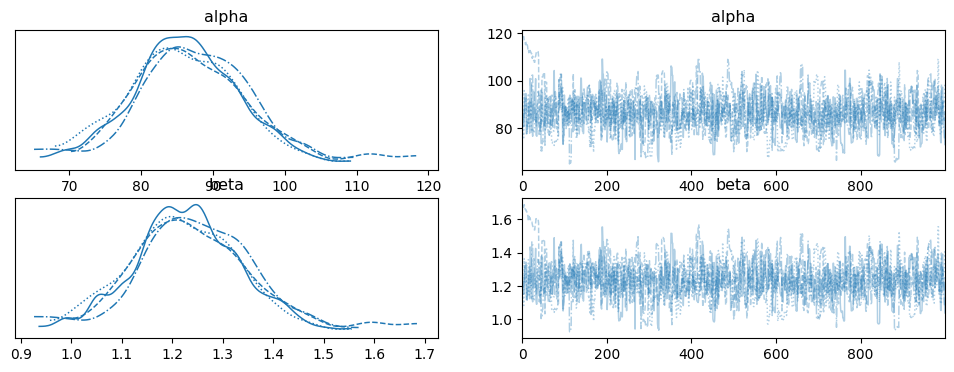

         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  86.739  7.972  72.828  102.852      0.402    0.308     473.0     240.0   
beta    1.236  0.114   1.037    1.467      0.006    0.004     473.0     239.0   

       r_hat  
alpha   1.01  
beta    1.01  


In [17]:

import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

height_data = df['Height'].values

gamma_height_model = pm.Model()
with gamma_height_model:
    alpha = pm.Exponential("alpha", 1.0)
    beta = pm.Exponential("beta", 1.0)
    theta = pm.Gamma("theta", alpha=alpha, beta=beta, observed=height_data)
    trace_height = pm.sample(1000, chains=4, random_seed=333)

az.plot_trace(trace_height)
plt.show()

print(az.summary(trace_height))


Question 4

In [18]:

rhat_height = az.rhat(trace_height)
print("MCMC Split-Rhats for Height Model:", {k: np.round(v.values, 4) for k, v in rhat_height.items()})

MCMC Split-Rhats for Height Model: {'alpha': 1.0098, 'beta': 1.0098}


array([<Axes: title={'center': '95.0% HDI'}>], dtype=object)

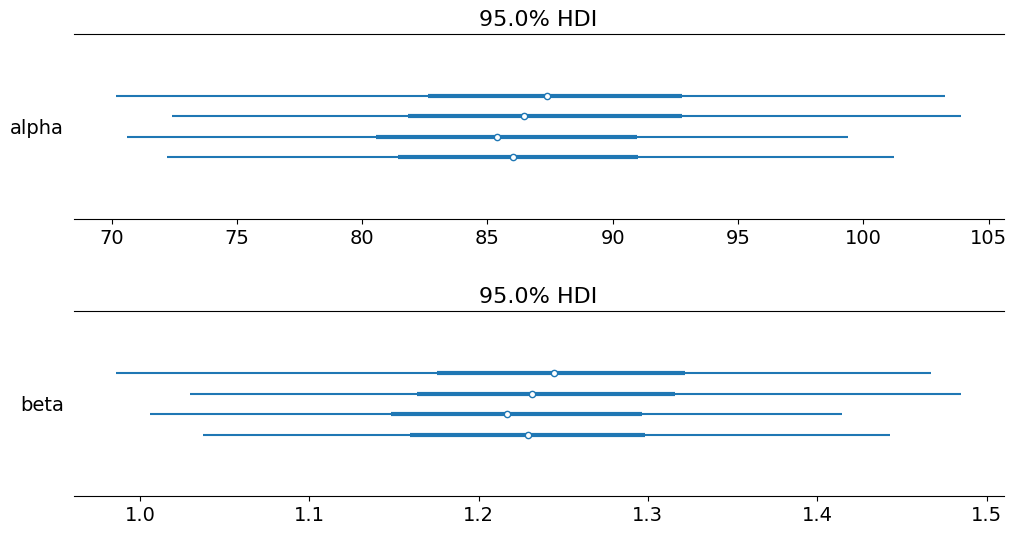

In [19]:
fig,ax = plt.subplots(2,1,figsize =(12,6))
plt.subplots_adjust(hspace=0.5)
az.plot_forest(trace_height, var_names=["alpha"], combined=False, hdi_prob=0.95, ax=ax[0])
az.plot_forest(trace_height, var_names=["beta"], combined=False, hdi_prob=0.95, ax=ax[1])
